# Machine Learning applied to MuJoCo environment

* ### Author: Mowibox (Ousmane THIONGANE)
* ### Date: November 4th, 2024

## Imports

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MSE
from sklearn.preprocessing import MinMaxScaler # We will see later
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model, save_model

2024-11-27 15:02:59.613895: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 15:02:59.801218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732716179.869870   19889 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732716179.889741   19889 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 15:03:00.046263: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## I - Context 

The main goal of this project is to create a Machine Learning model and training it to learn Forward Kinematics (by configuring an input value for the position and orientation of the end effector of a robotic arm, we return the values of the joints that enable this point to be reached).

## II - Datasets generation

In this part, we will prepare the data to perform a regression the by generatinig the datasets.

### 1) 2D with 2 joints

Firstly, we record a sequence with by launching the script with the command line: `python3 run.py -env r2 -seed 2184503 -steps 100000 --log > 2R_2184503_100.csv`. This allows us to save the data in a csv and display it with pandas

The filename format is "\<model>\_\<seed>\_\<nr. of samples>.csv". Here 2R is the 2D with 2 joints model, 2184503 for the random seed 2184503 and 100 for 100k steps:

In [3]:
filepath_2R = r'data/2R_2184503_100.csv'
df_2R = pd.read_csv(filepath_2R, sep=";", header=0).copy()

display(df_2R.head(5))
df_2R.info()

,j0,j1,cos(j0),cos(j1),sin(j0),sin(j1),ee_x,ee_y,ee_qw,ee_qz
0,0.034,0.003,0.999,1.000,0.034,0.003,0.210,0.007,1.000,0.018
1,0.048,0.004,0.999,1.000,0.048,0.004,0.210,0.010,1.000,0.026
2,0.073,0.038,0.997,0.999,0.073,0.038,0.209,0.020,0.998,0.056
3,0.093,0.098,0.996,0.995,0.093,0.098,0.208,0.030,0.995,0.096
4,0.136,0.153,0.991,0.988,0.135,0.152,0.205,0.045,0.990,0.144


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   j0        100000 non-null  float64
 1    j1       100000 non-null  float64
 2    cos(j0)  100000 non-null  float64
 3    cos(j1)  100000 non-null  float64
 4    sin(j0)  100000 non-null  float64
 5    sin(j1)  100000 non-null  float64
 6    ee_x     100000 non-null  float64
 7    ee_y     100000 non-null  float64
 8    ee_qw    100000 non-null  float64
 9    ee_qz    100000 non-null  float64
dtypes: float64(10)
memory usage: 7.6 MB


The .csv contains many informations about the simulation such as:
- The joints angles $j_0$, $j_1$
- The sine and the cosine of the joints angles: $\cos(j_0)$, $\sin(j_0)$, $\cos(j_1)$, $\sin(j_1)$
- The end-effector pose: $(x,y) = (ee_x, ee_y)$
- The end-effector orientation, based on quaternions: $q = (w,z) = (\cos(\frac{\theta_z}{2}), \sin(\frac{\theta_z}{2})) = ((ee_{qw})$, $(ee_{qz}))$ 



#### 1.a) Joint angles

In [4]:
X_2R = df_2R[[' cos(j0)', ' sin(j0)', ' cos(j1)', ' sin(j1)']].values

X_2R = pd.DataFrame(X_2R, columns=['cos(j0)', 'sin(j0)', 'cos(j1)', 'sin(j1)'])
display(X_2R.head(5))

,cos(j0),sin(j0),cos(j1),sin(j1)
0,0.999,0.034,1.000,0.003
1,0.999,0.048,1.000,0.004
2,0.997,0.073,0.999,0.038
3,0.996,0.093,0.995,0.098
4,0.991,0.135,0.988,0.152


#### 1.b) Fingertip position

In [5]:
y_2R_pos = df_2R[[' ee_x', ' ee_y']].values

#### 1.c) Fingertip orientation

In [6]:
y_2R_ori = df_2R[[' ee_qw', ' ee_qz']].values

Here, I choose to merge the end-effector position and orientation in one dataframe, so that my model can return both, and thus slice the output I need depending of the situation. 

In [7]:
y_2R = pd.concat([pd.DataFrame(y_2R_pos, columns=['ee_x', 'ee_y']), 
                         pd.DataFrame(y_2R_ori, columns=['ee_qw', 'ee_qz'])], axis=1)

display(y_2R.head(5))

,ee_x,ee_y,ee_qw,ee_qz
0,0.210,0.007,1.000,0.018
1,0.210,0.010,1.000,0.026
2,0.209,0.020,0.998,0.056
3,0.208,0.030,0.995,0.096
4,0.205,0.045,0.990,0.144


### 2) 2D with 3 joints 

The 3R robot .csv contains the following informations:
- The joints angles $j_0$, $j_1$, $j_2$ 
- The sine and the cosine of the joints angles: $\cos(j_0)$, $\sin(j_0)$, $\cos(j_1)$, $\sin(j_1)$, $\cos(j_2)$, $\sin(j_2)$
- The end-effector pose: $(x,y) = (ee_x, ee_y)$
- The end-effector orientation, based on quaternions: $q = (w,z) = (\cos(\frac{\theta_z}{2}), \sin(\frac{\theta_z}{2})) = ((ee_{qw})$, $(ee_{qz}))$ 


In [8]:
filepath_3R = r'data/3R_2184503_100.csv'
df_3R = pd.read_csv(filepath_3R, sep=";", header=0).copy()

display(df_3R.head(5))
df_3R.info()

,j0,j1,j2,cos(j0),cos(j1),cos(j2),sin(j0),sin(j1),sin(j2),ee_x,ee_y,ee_qw,ee_qz
0,0.034,0.003,-0.002,0.999,1.000,1.000,0.034,0.003,-0.002,0.310,0.011,1.000,0.017
1,0.047,0.004,-0.003,0.999,1.000,1.000,0.047,0.004,-0.003,0.310,0.015,1.000,0.024
2,0.105,0.001,-0.008,0.994,1.000,1.000,0.105,0.001,-0.008,0.308,0.032,0.999,0.049
3,0.222,-0.009,-0.014,0.975,1.000,1.000,0.220,-0.009,-0.014,0.303,0.065,0.995,0.099
4,0.369,-0.042,-0.041,0.933,0.999,0.999,0.361,-0.042,-0.041,0.293,0.099,0.990,0.143


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   j0        100000 non-null  float64
 1    j1       100000 non-null  float64
 2    j2       100000 non-null  float64
 3    cos(j0)  100000 non-null  float64
 4    cos(j1)  100000 non-null  float64
 5    cos(j2)  100000 non-null  float64
 6    sin(j0)  100000 non-null  float64
 7    sin(j1)  100000 non-null  float64
 8    sin(j2)  100000 non-null  float64
 9    ee_x     100000 non-null  float64
 10   ee_y     100000 non-null  float64
 11   ee_qw    100000 non-null  float64
 12   ee_qz    100000 non-null  float64
dtypes: float64(13)
memory usage: 9.9 MB


The processing of the data is basically the same as on the previous part:

#### 2.a) Joint angles

In [9]:
X_3R = df_3R[[' cos(j0)', ' sin(j0)', ' cos(j1)', ' sin(j1)', ' cos(j2)', ' sin(j2)']].values
X_3R = pd.DataFrame(X_3R, columns=['cos(j0)', 'sin(j0)', 'cos(j1)', 'sin(j1)', 'cos(j2)', 'sin(j2)'])
display(X_3R.head(5))

,cos(j0),sin(j0),cos(j1),sin(j1),cos(j2),sin(j2)
0,0.999,0.034,1.000,0.003,1.000,-0.002
1,0.999,0.047,1.000,0.004,1.000,-0.003
2,0.994,0.105,1.000,0.001,1.000,-0.008
3,0.975,0.220,1.000,-0.009,1.000,-0.014
4,0.933,0.361,0.999,-0.042,0.999,-0.041


#### 2.b) Fingertip position

In [10]:
y_3R_pos = df_3R[[' ee_x', ' ee_y']].values

#### 2.c) Fingertip orientation

In [11]:
y_3R_ori = df_3R[[' ee_qw', ' ee_qz']].values

In [12]:
y_3R = pd.concat([pd.DataFrame(y_3R_pos, columns=['ee_x', 'ee_y']), 
                         pd.DataFrame(y_3R_ori, columns=['ee_qw', 'ee_qz'])], axis=1)

display(y_3R.head(5))

,ee_x,ee_y,ee_qw,ee_qz
0,0.310,0.011,1.000,0.017
1,0.310,0.015,1.000,0.024
2,0.308,0.032,0.999,0.049
3,0.303,0.065,0.995,0.099
4,0.293,0.099,0.990,0.143


### 3) 3D with 5 joints

Since the 5R robot .csv is a 3D-case, the end-effector pose will contain more components:
- The joints angles $j_0$, $j_1$, $j_2$, $j_3$, $j_4$ 
- The sine and the cosine of the joints angles: $\cos(j_0)$, $\sin(j_0)$, $\cos(j_1)$, $\sin(j_1)$, $\cos(j_2)$, $\sin(j_2)$, $\cos(j_3)$, $\sin(j_3)$, $\cos(j_4)$, $\sin(j_4)$
- The end-effector pose: $(x,y,z) = (ee_x, ee_y, ee_z)$
- The end-effector orientation, based on quaternions: $q = (w,x,y,z) = (\cos(\frac{\theta}{2}), \sin(\frac{\theta}{2}), \sin(\frac{\theta}{2}), \sin(\frac{\theta}{2})) = ((ee_{qw}), (ee_{qx}), (ee_{qy}), (ee_{qz}))$ 


In [13]:
filepath_5R = r'data/5R_2184503_100.csv'
df_5R = pd.read_csv(filepath_5R, sep=";", header=0).copy()

display(df_5R.head(5))
df_5R.info()

,j0,j1,j2,j3,j4,cos(j0),cos(j1),cos(j2),cos(j3),cos(j4),...,sin(j2),sin(j3),sin(j4),ee_x,ee_y,ee_z,ee_qw,ee_qx,ee_qy,ee_qz
0,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.0,...,0.000,0.000,0.000,0.000,0.000,0.590,1.000,0.000,0.000,0.000
1,0.014,0.001,-0.001,0.031,-0.005,1.000,1.000,1.000,1.000,1.0,...,-0.001,0.031,-0.005,0.007,0.001,0.590,1.000,-0.003,0.016,0.007
2,0.037,0.031,-0.005,0.096,-0.011,0.999,1.000,1.000,0.995,1.0,...,-0.005,0.096,-0.011,0.035,0.003,0.588,0.998,-0.007,0.061,0.019
3,0.034,0.067,-0.049,0.146,0.014,0.999,0.998,0.999,0.989,1.0,...,-0.049,0.146,0.014,0.048,-0.000,0.587,0.996,0.006,0.082,0.016
4,0.036,0.074,-0.157,0.160,0.030,0.999,0.997,0.988,0.987,1.0,...,-0.156,0.160,0.030,0.017,-0.003,0.589,0.999,0.014,0.039,0.017


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   j0        100000 non-null  float64
 1    j1       100000 non-null  float64
 2    j2       100000 non-null  float64
 3    j3       100000 non-null  float64
 4    j4       100000 non-null  float64
 5    cos(j0)  100000 non-null  float64
 6    cos(j1)  100000 non-null  float64
 7    cos(j2)  100000 non-null  float64
 8    cos(j3)  100000 non-null  float64
 9    cos(j4)  100000 non-null  float64
 10   sin(j0)  100000 non-null  float64
 11   sin(j1)  100000 non-null  float64
 12   sin(j2)  100000 non-null  float64
 13   sin(j3)  100000 non-null  float64
 14   sin(j4)  100000 non-null  float64
 15   ee_x     100000 non-null  float64
 16   ee_y     100000 non-null  float64
 17   ee_z     100000 non-null  float64
 18   ee_qw    100000 non-null  float64
 19   ee_qx    100000 non-null  float64
 20   ee_q

#### 3.a) Joint angles 

In [14]:
X_5R = df_5R[[' cos(j0)', ' sin(j0)', ' cos(j1)', ' sin(j1)', ' cos(j2)', ' sin(j2)', ' cos(j3)', ' sin(j3)', ' cos(j4)', ' sin(j4)']].values

X_5R = pd.DataFrame(X_5R, columns=['cos(j0)', 'sin(j0)', 'cos(j1)', 'sin(j1)', 'cos(j2)', 'sin(j2)', 'cos(j3)', 'sin(j3)', 'cos(j4)', 'sin(j4)'])
display(X_5R.head(5))

,cos(j0),sin(j0),cos(j1),sin(j1),cos(j2),sin(j2),cos(j3),sin(j3),cos(j4),sin(j4)
0,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.0,0.000
1,1.000,0.014,1.000,0.001,1.000,-0.001,1.000,0.031,1.0,-0.005
2,0.999,0.037,1.000,0.031,1.000,-0.005,0.995,0.096,1.0,-0.011
3,0.999,0.034,0.998,0.067,0.999,-0.049,0.989,0.146,1.0,0.014
4,0.999,0.036,0.997,0.074,0.988,-0.156,0.987,0.160,1.0,0.030


#### 3.b) Fingertip position

In [15]:
y_5R_pos = df_5R[[' ee_x', ' ee_y', ' ee_z']].values

#### 3.c) Fingertip orientation

In [16]:
y_5R_ori = df_5R[[' ee_qw', ' ee_qx', ' ee_qy', ' ee_qz']].values

In [17]:
y_5R = pd.concat([pd.DataFrame(y_5R_pos, columns=['ee_x', 'ee_y', "ee_z"]), 
                         pd.DataFrame(y_5R_ori, columns=['ee_qw', 'ee_qx', 'ee_qy', 'ee_qz'])], axis=1)

display(y_5R.head(5))

,ee_x,ee_y,ee_z,ee_qw,ee_qx,ee_qy,ee_qz
0,0.000,0.000,0.590,1.000,0.000,0.000,0.000
1,0.007,0.001,0.590,1.000,-0.003,0.016,0.007
2,0.035,0.003,0.588,0.998,-0.007,0.061,0.019
3,0.048,-0.000,0.587,0.996,0.006,0.082,0.016
4,0.017,-0.003,0.589,0.999,0.014,0.039,0.017


## III - Learning Forward Kinematics

### 1) 2D with 2 joints

We are dividing the dataset to randomly take 80% of the data for training the model, and 20% for testing. 

In [18]:
X_2R_train, X_2R_test, y_2R_train, y_2R_test = train_test_split(X_2R, y_2R, test_size=0.2, random_state=2184503)
print(X_2R_train.shape, y_2R_train.shape)
print(y_2R_test.shape, y_2R_test.shape)

(80000, 4) (80000, 4)
(20000, 4) (20000, 4)


##### Model definition 

In [19]:
model_2R = Sequential()
model_2R.add(Input((X_2R_train.shape[1],)))
model_2R.add(Dense(64, activation="relu"))
model_2R.add(Dense(32, activation="relu"))
model_2R.add(Dense(y_2R_train.shape[1], activation="linear"))

model_2R.summary()

2024-11-27 15:03:04.858747: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,532 (9.89 KB)

 Trainable params: 2,532 (9.89 KB)

 Non-trainable params: 0 (0.00 B)

##### Loss function & optimizer

In [20]:
model_2R.compile(loss=MSE, optimizer=Adam(learning_rate=0.001))

##### Solver - Training phase

In [39]:
epochs = 50
history_2R = model_2R.fit(X_2R_train, y_2R_train,
                    epochs=epochs,
                    validation_data=(X_2R_test, y_2R_test),
                    verbose=1)

print(f"== Final loss ==\nTrain: {history_2R.history['loss'][-1]}\nTest: {history_2R.history['val_loss'][-1]}")

Epoch 1/50


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0481 - val_loss: 0.0466
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0485 - val_loss: 0.0465
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0477 - val_loss: 0.0465
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0489 - val_loss: 0.0465
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0487 - val_loss: 0.0471
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0484 - val_loss: 0.0465
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0479 - val_loss: 0.0468
Epoch 8/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0477 - val_loss: 0.0467
Epoch 9/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0484 - val_loss: 0.0465
Epoch 10/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0480 - val_loss: 0.0466
Epoch 11/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 950us/step - loss: 0.0477 - val_loss: 0.0463
Epoch 12/50
2500/2500 ━━━━━━━━━━━━━━━━━

In [22]:
def displayLearningCurve(history, epochs: int):
    """
    Displays the model loss

    @param history: The model history
    @param epochs: The number of epochs
    """
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title("Model loss")
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Test'], loc='upper right')

    plt.tight_layout()
    plt.show()

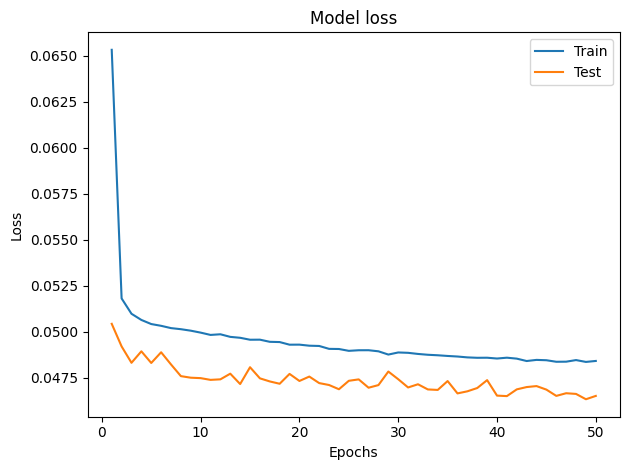

In [ ]:
displayLearningCurve(history=history_2R, 
                    epochs=epochs)

##### Hyper-parameter search

##### Testing the model - Machine Learning vs Traditionnal method

In [24]:
def FK(model, theta):
    """
    Predicts the Forward Kinematics for a defined set of angles
    @param model: The machine learning model
    @param theta: The tensor of angle inputs
    """

    theta = tf.convert_to_tensor(theta, dtype=tf.float32) 
    n = theta.shape[0]
    if n == 2:  # 2R Robot
        features = tf.stack([tf.cos(theta[0]), tf.sin(theta[0]),
                             tf.cos(theta[1]), tf.sin(theta[1])])
    elif n == 3:  # 3R Robot
        features = tf.stack([tf.cos(theta[0]), tf.sin(theta[0]),
                             tf.cos(theta[1]), tf.sin(theta[1]),
                             tf.cos(theta[2]), tf.sin(theta[2])])
    elif n == 5:  # 5R Robot
        features = tf.stack([tf.cos(theta[0]), tf.sin(theta[0]),
                             tf.cos(theta[1]), tf.sin(theta[1]),
                             tf.cos(theta[2]), tf.sin(theta[2]),
                             tf.cos(theta[3]), tf.sin(theta[3]),
                             tf.cos(theta[4]), tf.sin(theta[4])])
    else:
        raise ValueError("Error! size of theta must be 2, 3, or 5!")
    
    # Reshape to batch size 1
    t = tf.reshape(features, shape=(1, 2 * n))
    out = model(t)
    
    # Reshape to the appropriate output vector
    output_shape = 4 if n in [2, 3] else 7
    out = tf.reshape(out, shape=(output_shape,))

    return out

In [ ]:
THETA_LST = [(0,0), (np.pi/2, np.pi/2), (np.pi/2, 0)]

for theta in THETA_LST:
    ee_x_pred, ee_y_pred, _, _ = FK(model_2R, theta)
    print(f"Example with (j0, j1) = {theta}")
    print(f"End-effector predicted X-position: {ee_x_pred}")
    print(f"End-effector predicted Y-position: {ee_y_pred}")
    print("\n")


Example with (j0, j1) = (0, 0)
End-effector predicted X-position: 0.20506621897220612
End-effector predicted Y-position: -0.0015915818512439728


Example with (j0, j1) = (1.5707963267948966, 1.5707963267948966)
End-effector predicted X-position: -0.10471318662166595
End-effector predicted Y-position: 0.0959690511226654


Example with (j0, j1) = (1.5707963267948966, 0)
End-effector predicted X-position: -0.011846015229821205
End-effector predicted Y-position: 0.21631857752799988




In [26]:
def dispFK_2R(model, theta):
    """
    Plots the Forward Kinematics 2R comparison between Analytical method and ML model.

    model: The ML model
    theta: The joint angles for the 2R robot
    """


    ee_x_pred, ee_y_pred, qw, qz = model 

    j0, j1 = theta
    # Based on the specified robot parameters
    l1 = 0.1  # First link
    l2 = 0.1  # Second link
    
    # FK Analytical equations
    x1 = l1 * np.cos(j0)
    y1 = l1 * np.sin(j0)
    x2 = x1 + l2 * np.cos(j0 + j1)
    y2 = y1 + l2 * np.sin(j0 + j1)

    plt.figure(figsize=(5, 5))
    
    plt.plot([0, x1], [0, y1], 'c-', marker='o', label="Link 1 (Analytical)")
    plt.plot([x1, x2], [y1, y2], 'cyan', marker='o', label="Link 2 (Analytical)")

    # Plot ML-predicted end-effector
    plt.plot(ee_x_pred, ee_y_pred, 'mx', label="End-Effector (Model Prediction)")

    plt.xlim(-0.25, 0.25)
    plt.ylim(-0.25, 0.25)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Analytical and Model Prediciton Comparison")
    plt.grid()
    plt.legend()
    plt.show()

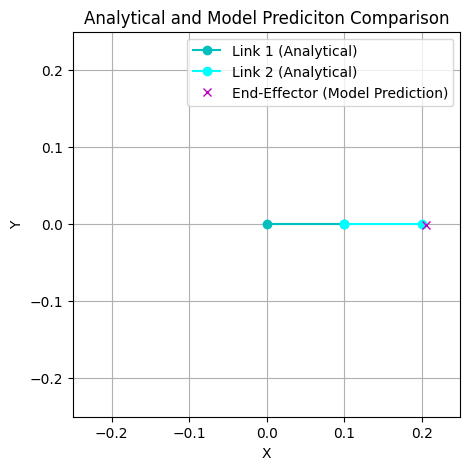

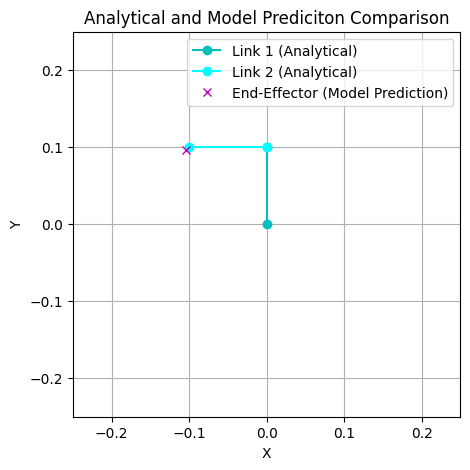

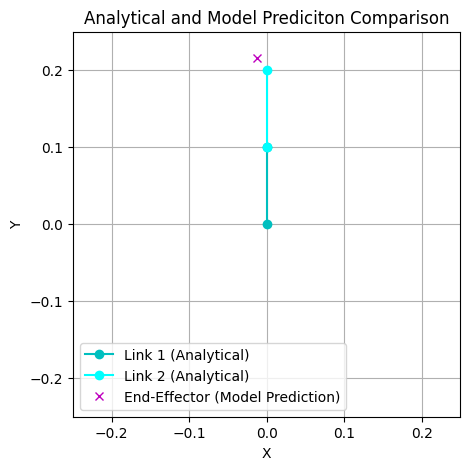

In [27]:
for theta in THETA_LST:
    result_model = FK(model_2R, theta)  
    dispFK_2R(result_model, theta)

##### Jacobian matrix

In [28]:
@tf.function
def FK_Jacobian_pred(model, x):
    """
    Computes the Forward Kinematics Jacobian matrix
    
    @param model: The machine learning model
    @param x: The tuple of angle inputs
    """
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y = FK(model, x)
        y = y[:2] # Removing the quaternion part for the Jacobian computation
    return tape.jacobian(y, x)


def FK_Jacobian_analytic(theta):
    """
    Computes the Analytic Forward Kinematics Jacobian matrix
    @param theta: The tuple of angle inputs
    """
    l1, l2, = 0.1, 0.1
    j0, j1 = theta
    analytical_J = np.array([[-l1*np.sin(j0)-l2*np.sin(j0+j1), -l2*np.sin(j0+j1)],
                             [ l1*np.cos(j0)+l2*np.cos(j0+j1),  l2*np.cos(j0+j1)]])
    return analytical_J

In [34]:
theta = [np.pi/4, np.pi/2]  
theta_tf = tf.convert_to_tensor(theta, dtype=tf.float32)

learned_J = FK_Jacobian_pred(model_2R, theta_tf)
print(f"Jacobian Matrix predicted:\n{learned_J}")

analytical_J = FK_Jacobian_analytic(theta)
print(f"Jacobian Matrix analytical:\n{learned_J}")


Jacobian Matrix predicted:
[[-0.16543235 -0.05983393]
 [-0.02068387 -0.10235264]]
Jacobian Matrix analytical:
[[-0.16543235 -0.05983393]
 [-0.02068387 -0.10235264]]


### 2) 2D with 3 joints

In [37]:
X_3R_train, X_3R_test, y_3R_train, y_3R_test = train_test_split(X_3R, y_3R, test_size=0.2, random_state=2184503)
print(X_3R_train.shape, y_3R_train.shape)
print(y_3R_test.shape, y_3R_test.shape)

(80000, 6) (80000, 4)
(20000, 4) (20000, 4)


In [38]:
model_3R = Sequential()
model_3R.add(Input((X_3R_train.shape[1],)))
model_3R.add(Dense(64, activation="relu"))
model_3R.add(Dense(32, activation="relu"))
model_3R.add(Dense(y_3R_train.shape[1], activation="linear"))

model_3R.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,660 (10.39 KB)

 Trainable params: 2,660 (10.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_3R.compile(loss=MSE, optimizer=Adam(learning_rate=0.001))

epochs = 50
history_3R = model_3R.fit(X_3R_train, y_3R_train,
                    epochs=epochs,
                    validation_data=(X_3R_test, y_3R_test),
                    verbose=1)

print(f"== Final loss ==\nTrain: {history_3R.history['loss'][-1]}\nTest: {history_3R.history['val_loss'][-1]}")

Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0816 - val_loss: 0.0502
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0495 - val_loss: 0.0480
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0487 - val_loss: 0.0479
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0481 - val_loss: 0.0477
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0480 - val_loss: 0.0475
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0481 - val_loss: 0.0479
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0471 - val_loss: 0.0475
Epoch 8/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0479 - val_loss: 0.0477
Epoch 9/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0475 - val_loss: 0.0476
Epoch 10/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0469 - val_loss: 0.0473
Epoch 11/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 960us/step - loss: 0.0475 - val_loss: 0.0472
Epoch 12/50
2500/2500 ━━━━━━

In [ ]:
displayLearningCurve(history=history_3R, 
                    epochs=epochs)

### 3) 3D with 5 joints

## IV - Inverse Kinematics 

### 1) 2D with 2 joints

### 2) 2D with 3 joints

### 3) 3D with 5 joints

## V - Robot Control 

### 1) 2D with 2 joints

### 2) 2D with 3 joints

### 3) 2D with 5 joints

## VI - Deep Reinforcement Learning 

### 1) 2D with 2 joints

### 2) 2D with 3 joints

### 3) 3D with 5 joints